## Degron prediction

This notebook is meant to train a machine learning model to predict the biological feasibility of degron motifs.

In [1]:
# import needed packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42

First, we read in features for training a degron predictor. Positive labels represent experimentally verified degrons from the "Degrons in cancer" review by Meszaros et al., while negative labels are randomly chosen positions within the same set of proteins.

In [3]:
# read in data
df = pd.read_csv('data/degron_pred/degron_snvbox_annot.txt', sep='\t', na_values=['None'])
degron_info = pd.read_csv('data/degron_pred/degron_file.txt', sep='\t')
degron_info['frac_protein_len'] = degron_info['Pos'] / degron_info['aaLen']
degron_info['ID'] = degron_info['RefseqP'] + '_' + degron_info['mutation']
df = pd.merge(df, degron_info[['ID', 'frac_protein_len']], on='ID', how='left')

# prepare the feature dataframe and class labels
feat_cols = [c for c in df.columns[2:] 
             if 'DiffProb' not in c and 'ProbMut' not in c
            ]
feat_df = df.groupby('UID')[feat_cols].mean()
feat_df = feat_df.fillna(feat_df.mean())
y = [0 if ix.startswith('SIM_') else 1 for ix in feat_df.index.values]

Now, train/evaluate a random forest.

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, oob_score=True)

from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve

myscores = cross_val_predict(rf, feat_df, y, cv=20, method='predict_proba')[:,1]

Plot roc curve.

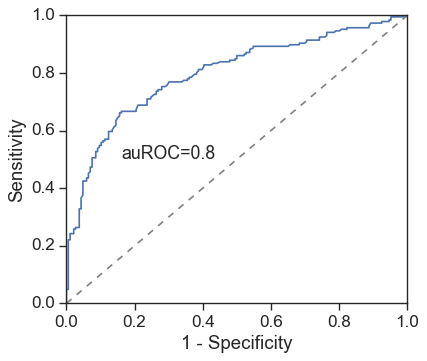

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
y = pd.Series(y)
fpr, tpr, thresholds = roc_curve(y, myscores)
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.4):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], ls='--', color='gray')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.text(.16, .5,'auROC={:.2g}'.format(roc_auc_score(y, myscores)), size=16)
    plt.gcf().set_size_inches(5.5,4.5)
    #plt.savefig('figures/degron_pred_auc.pdf')

In [8]:
stats.mannwhitneyu(myscores[y==0], myscores[y==1])

MannwhitneyuResult(statistic=7002.0, pvalue=1.567972332147586e-23)

The majority score will be used to predict whether it is a degron.

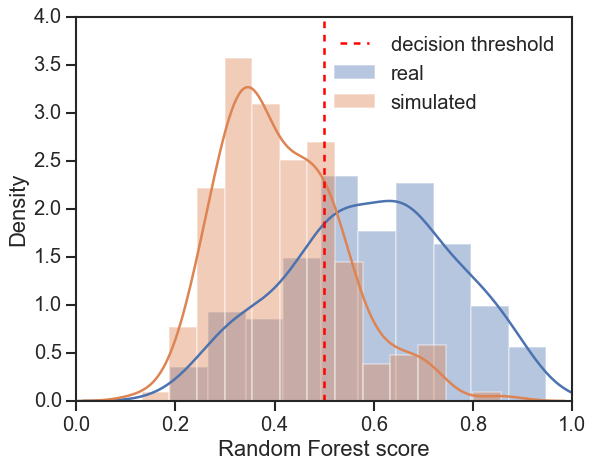

In [9]:
with sns.axes_style('ticks'), sns.plotting_context('talk', font_scale=1.1):
    sns.distplot(myscores[np.array(y)==1], label='real')
    sns.distplot(myscores[np.array(y)==0], label='simulated')
    plt.axvline(0.5, color='red', ls='--', label='decision threshold')
    plt.xlim(0,1)
    plt.legend(loc='best', frameon=False)
    plt.xlabel('Random Forest score')
    plt.ylabel('Density')

Plot the feature importance.

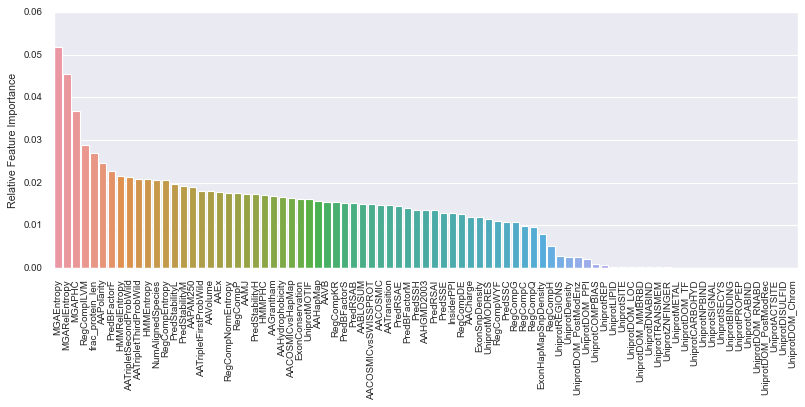

In [10]:
model = rf.fit(feat_df, y)
s = pd.Series(model.feature_importances_, feat_df.columns)
s = s.sort_values(ascending=False)

# plot feature importance
with sns.plotting_context('notebook', font_scale=.8):
    sns.barplot(s.index, s)
    plt.xticks(rotation=90)
    plt.gcf().set_size_inches(12, 4)
    plt.ylabel('Relative Feature Importance')
    #plt.savefig('figures/feature_importance.pdf')

Next, we'll plot a few of the important features to see whether high or low feature values correlate with more likely to be a degron.

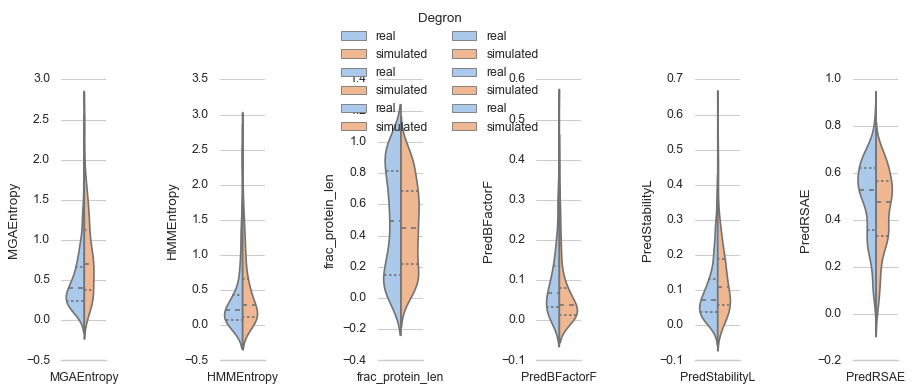

In [11]:
plot_df = feat_df.copy()
plot_df['degron'] = 'simulated'
plot_df.loc[np.array(y)==1, 'degron'] = 'real'
feat_cols = ['MGAEntropy', 'HMMEntropy', 'frac_protein_len', 'PredBFactorF', 'PredStabilityL', 'PredRSAE']
tmp = pd.melt(plot_df, id_vars=['degron'], value_vars=feat_cols,
              var_name='feature')
#sns.boxplot(x='y', y='frac_protein_len', data=plot_df)
#sns.stripplot(x='y', y='PredBFactorF', data=plot_df)
with sns.axes_style("whitegrid",), sns.plotting_context('notebook', font_scale=1.0):
    fig, axes = plt.subplots(1, len(feat_cols))
    for i in range(len(feat_cols)):
        ax = sns.violinplot(x='feature', y='value', hue='degron', 
                            data=tmp[tmp['feature']==feat_cols[i]],split=True, 
                            inner="quart", palette=sns.color_palette("pastel"), legend=False, 
                            ax=axes[i])
        sns.despine(left=True)
        ax.set_ylabel(feat_cols[i])
        ax.set_xlabel('')
        ax.get_legend().remove()
    plt.tight_layout()
    fig.set_size_inches((12, 4))
    lgd = fig.legend(loc='upper center', title='Degron', frameon=False, ncol=2, bbox_to_anchor=(0.5, 1.2))
#plt.savefig('figures/degron_features.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

### Filter COP1 motifs

Now we will try to filter COP1 motif hits based on the random forest predictions. The first step is to prepare the set of features to be scored by the random forest model.

In [13]:
# read data
df = pd.read_csv('data/degron_pred/cop1_degron_snvbox_annot.txt', sep='\t', na_values=['None'])
degron_info = pd.read_csv('data/degron_pred/cop1_degron_file.txt', sep='\t')
#df = pd.read_csv('data/all_hits_snvbox_input_formatted_annot.txt', sep='\t', na_values=['None'])
#degron_info = pd.read_csv('data/all_hits_snvbox_input.txt', sep='\t')
degron_info['frac_protein_len'] = degron_info['Pos'] / degron_info['aaLen']
degron_info['ID'] = degron_info['RefseqP'] + '_' + degron_info['mutation']
df = pd.merge(df, degron_info[['ID', 'frac_protein_len']], on='ID', how='left')

# create feature df
feat_cols = [
    c for c in df.columns[2:] 
    if 'DiffProb' not in c and 'ProbMut' not in c
]
feat_df = df.groupby('UID')[feat_cols].mean()
feat_df = feat_df.fillna(feat_df.mean())

In [14]:
degron_info.head()
tmp = pd.read_table('data/degron_pred/all_motif_hits.txt')
tmp.head()
tmp['DegronID'] = tmp['NAME']+'_'+tmp['ACC']+'_'+tmp['START'].astype(str)+'-'+tmp['END'].astype(str)

Now, we actually score the motifs.

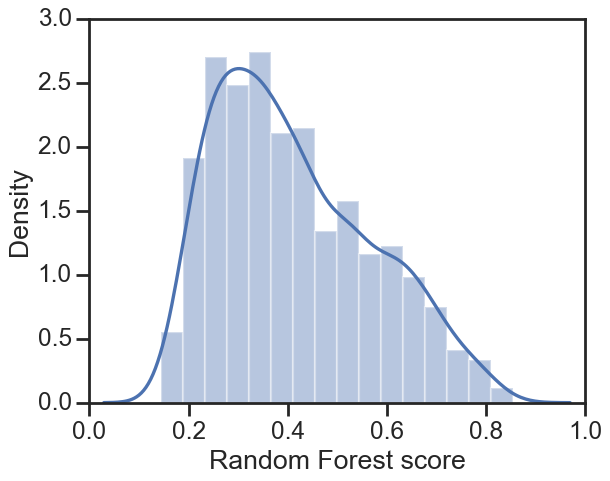

In [15]:
# score the motif examples for degron potential
result = feat_df.copy()
result['Random Forest score'] = model.predict_proba(feat_df)[:,1]
# merge the score information back into the data frame
result = pd.merge(result, degron_info[['DegronID', 'geneSymbol']].drop_duplicates('DegronID'), 
                  left_index=True, right_on='DegronID', how='left')

# plot the distribution of scores
with sns.axes_style('ticks'), sns.plotting_context('poster'):
    sns.distplot(result['Random Forest score'])
    plt.ylabel('Density')

In [16]:
result = pd.merge(result, tmp[['DegronID', 'MOTIF']], on='DegronID', how='left')

In [17]:
top_result = result[result['Random Forest score']>0.5].sort_values('Random Forest score', ascending=False).groupby('MOTIF').head(50)

Here, we format the output of the data frame.

In [18]:
# read in genes that are expressed at the RNA-level
expr_df = pd.read_csv('data/degron_pred/expressed_genes.txt', sep='\t').rename(columns={'Symbol': 'geneSymbol'})
expr_genes = expr_df.loc[expr_df['expressed']==1, 'geneSymbol'].unique()

# label expressed genes
result['expressed'] = 0
result.loc[result['geneSymbol'].isin(expr_genes), 'expressed'] = 1

# merge mouse gene symbol
if 'MouseSymbol' not in result.columns:
    result = pd.merge(result, expr_df[['geneSymbol', 'MouseSymbol']].drop_duplicates('geneSymbol'), 
                      on='geneSymbol', how='left')
    
# label genes with human and mouse motifs
mouse_motif = pd.read_csv('data/degron_pred/COP1_degron_short_motifs_mouse_with_human_gnames.txt', sep='\t').rename(columns={'HGNC.symbol': 'geneSymbol'})
result['mouse and human motif'] = 0
result.loc[result['geneSymbol'].isin(mouse_motif['geneSymbol'].values), 'mouse and human motif'] = 1

# label proteins in mass spec
diff_prot = pd.read_csv('data/degron_pred/diff_prot_abundance_RNA_adjusted.txt', sep='\t')
prot_genes = diff_prot.gene.unique()
result['In Mass Spec'] = 0
result.loc[result['MouseSymbol'].isin(prot_genes), 'In Mass Spec'] = 1

# save results
out_cols = ['MouseSymbol', 'geneSymbol', 'DegronID', 'expressed', 'mouse and human motif', 'In Mass Spec',
            'MGAEntropy', 'HMMEntropy', 'frac_protein_len', 'PredBFactorF','PredStabilityL', 
            'PredRSAE', 'Random Forest score']
#result[out_cols].sort_values('Random Forest score', ascending=False).to_csv('result/COP1_degron_motifs.txt', sep='\t', index=False)

Next, we compare the distribution of known cop1 targets to all other hits.

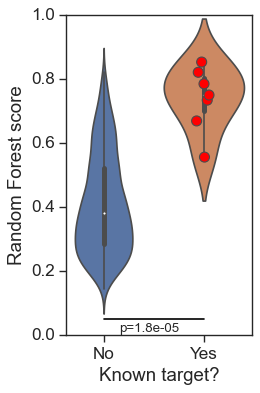

In [19]:
# label known targets
known_cop1_targets = [
 'Jun', 'Ets1', 'Ets2', 'Etv1',
 'Etv4', 'Etv5', 'Cebpa', 'Trp53', 'Mta1', 'Crtc2',
 'Foxo1', 'Acaca'
]
result['Known target?'] = 'No'
result.loc[result['MouseSymbol'].isin(known_cop1_targets), 'Known target?'] = 'Yes'
result['tmp'] = result['Random Forest score'].copy()
result.loc[result['Known target?']=='No', 'tmp'] = np.nan

# plot results
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.4):
    is_known = result['Known target?']=='Yes'
    _, pval = stats.mannwhitneyu(result.loc[is_known, 'Random Forest score'], result.loc[~is_known, 'Random Forest score'])
    sns.violinplot('Known target?', 'Random Forest score', data=result)
    sns.stripplot('Known target?', 'tmp', data=result, color='red', s=9, linewidth=1)
    plt.ylim(0,1)
    plt.ylabel('Random Forest score')
    plt.text(.15, 0.012, 'p={:.2g}'.format(pval), size =12)
    plt.plot([0, 1], [0.05, 0.05], color='black')
    plt.gcf().set_size_inches(3, 5)
    #plt.savefig('figures/degron/scores_for_cop1_targets.pdf')

